# Day 4-5
- **Image Augmentation** practice using other common tools (**change later?**)(using libraries like `tf.keras.image`, `imgaug` and `OpenCV`)
- **Integrating Advanced Augmentation** in CNN Pipeline
- ***Compare the results*** of your previous model which was trained on simple data and another one on new augmented data.

In [ ]:
# As always, my Deep Learning Survival Kit😆
import warnings
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

## OpenCV Data Augmentation

In [ ]:
# Loading CIFAR-10 dataset first
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [ ]:
def plot_images(img_arr, img_lbls):
  fig, axs = plt.subplots(1, 5)
  true_labels = [labels[i[0]] for i in img_lbls]
  for img, ax, label in zip(img_arr, axs, true_labels):
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
  plt.show()

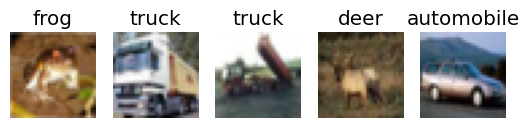

In [ ]:
plot_images(X_train[:5], y_train[:5])

In [ ]:
# Importing OpenCV module
import cv2

In [ ]:
X_train_rescaled, X_test_rescaled = X_train.astype(np.float32) / 255, X_test.astype(np.float32) / 255

In [ ]:
# Define data augmentation function using OpenCV
def augment_image(img):
    # Flip horizontally
    img = cv2.flip(img, 1)  # Horizontal flip
    # Rotate the image randomly
    angle = np.random.uniform(-15, 15)
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)  # Rotate
    img = cv2.warpAffine(img, M, (w, h))
    # Adjust brightness
    brightness_factor = np.random.uniform(0.7, 1.3)
    img = cv2.convertScaleAbs(img, alpha=brightness_factor)
    return img

In [ ]:
# Creating a TensorFlow dataset with augmentation
def create_augmented_dataset(x_train, y_train, batch_size=32):
    def data_gen(x, y):
        for img, label in zip(x, y):
            augmented_img = augment_image(img)
            yield augmented_img, label

    dataset = tf.data.Dataset.from_generator(
        lambda: data_gen(x_train, y_train),
        output_signature=(tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32), tf.TensorSpec(shape=(1,), dtype=tf.int32))
    )

    return dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Creating the augmented dataset
augmented_dataset = create_augmented_dataset(X_train_rescaled, y_train)

In [ ]:
# CNN "recreation"
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(augmented_dataset, epochs=20, steps_per_epoch=len(X_train) // 32, validation_data=(X_test_rescaled, y_test))  # steps_per_epoch has to be specified when you pass an infinitely repeating Dataset `object`

Epoch 1/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.2910 - loss: 1.9180 - val_accuracy: 0.2671 - val_loss: 2.0078
Epoch 2/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 3s 332us/step - accuracy: 0.4375 - loss: 1.7033 - val_accuracy: 0.2491 - val_loss: 2.0516
Epoch 3/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.4147 - loss: 1.6051 - val_accuracy: 0.3313 - val_loss: 1.9387
Epoch 4/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step - accuracy: 0.3125 - loss: 1.4333 - val_accuracy: 0.3313 - val_loss: 1.9489
Epoch 5/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - accuracy: 0.4528 - loss: 1.5182 - val_accuracy: 0.3202 - val_loss: 1.9924
Epoch 6/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - accuracy: 0.4375 - loss: 1.6250 - val_accuracy: 0.3179 - val_loss: 1.9908
Epoch 7/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.4681 - loss: 1.4787 - val_accuracy: 0.3904 - val_loss: 1.8169
Epoch 8/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 328us/step - accuracy: 0.4375 -

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_rescaled, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

### As we can see, the accuracy is pretty bad, but I assume the problem is that we train our model directly on the augmented data or because we have applied to many augmentations, which can worsen the performance of our model.

## `imgaug` Data Augmentation

In [ ]:
X_train_rescaled, X_test_rescaled = X_train.astype(np.float32) / 255, X_test.astype(np.float32) / 255

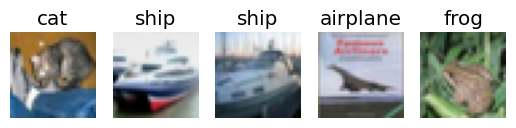

In [ ]:
plot_images(X_test_rescaled[:5], y_test[:5])

In [ ]:
import imgaug.augmenters as iaa
import numpy as np

In [ ]:
def data_gen(x_train, y_train, batch_size=32):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20)),
        iaa.GaussianBlur(sigma=(0.0, 1.0)),
    ])

    while True:
        indices = np.random.randint(0, len(x_train), batch_size)
        x_batch = x_train[indices]
        y_batch = y_train[indices]

        x_batch_aug = seq(images=x_batch)

        yield x_batch_aug, y_batch

In [ ]:
# CNN "recreation"
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train_rescaled.shape[1:]),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(data_gen(X_train_rescaled, y_train), epochs=30, steps_per_epoch=len(X_train) // 32,
          validation_data=(X_test_rescaled, y_test))

Epoch 1/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.3047 - loss: 1.8720 - val_accuracy: 0.4913 - val_loss: 1.3933
Epoch 2/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.4721 - loss: 1.4492 - val_accuracy: 0.5305 - val_loss: 1.3016
Epoch 3/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.5130 - loss: 1.3456 - val_accuracy: 0.5751 - val_loss: 1.1840
Epoch 4/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.5373 - loss: 1.2914 - val_accuracy: 0.5851 - val_loss: 1.1573
Epoch 5/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.5581 - loss: 1.2375 - val_accuracy: 0.6012 - val_loss: 1.1198
Epoch 6/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.5693 - loss: 1.2024 - val_accuracy: 0.6214 - val_loss: 1.0607
Epoch 7/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.5877 - loss: 1.1551 - val_accuracy: 0.6264 - val_loss: 1.0661
Epoch 8/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.5942 -

In [ ]:
def plot_accuracy_and_loss_comparison(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.show()

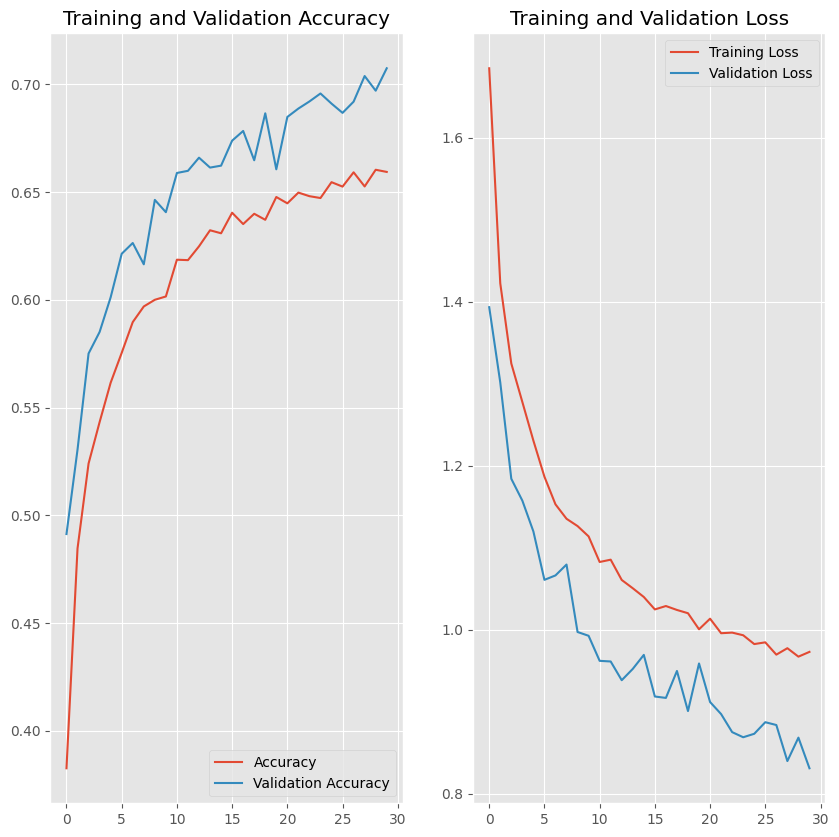

In [ ]:
plot_accuracy_and_loss_comparison(history, 30)

### So, we can see that compared to the previous model, this one performed really well (I think that I probably just used some inappropriate augmentations during the first try), including that I haven't tried to fine-tune the number of layers, different other initialisation algorithms, etc.
### In the next "chapter" I'll explore different regularisation techniques (although I have used one) and different types of optimisers (SGD, Adam, RMSProp, Momentum, Nesterov, etc.), which definetely have to improve the performance of our model.